# Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('seaborn')
import plotly.graph_objects as go
import talib

# Fetching Data

In [24]:
data = pd.read_csv("Nifty50.csv")

In [25]:
data

,datetime,open,high,low,close,volume
0,2020-07-01 09:15:00,10323.80,10355.70,10299.80,10328.55,0
1,2020-07-01 09:45:00,10328.40,10363.15,10328.40,10350.45,0
2,2020-07-01 10:15:00,10350.35,10350.35,10324.70,10331.20,0
3,2020-07-01 10:45:00,10330.35,10350.50,10318.55,10336.60,0
4,2020-07-01 11:15:00,10336.95,10371.85,10329.80,10362.35,0
...,...,...,...,...,...,...
6647,2022-07-20 13:15:00,16530.65,16567.00,16522.05,16555.95,0
6648,2022-07-20 13:45:00,16555.90,16565.00,16536.45,16547.05,0
6649,2022-07-20 14:15:00,16547.45,16547.80,16516.50,16519.75,0
6650,2022-07-20 14:45:00,16520.50,16542.40,16515.55,16516.20,0


# Data Manipulation

In [26]:
data=data.rename(columns={"close":"Close","open":"Open","high":"High","low":"Low"})

In [27]:
data.index = pd.DatetimeIndex(data['datetime'])
data=data.drop(columns=['datetime','volume'])

In [28]:
data['Typical Price']= (data['Close']+data['High']+data['Low'])/3  # Calculated the average or typical price

In [29]:
data.index

DatetimeIndex(['2020-07-01 09:15:00', '2020-07-01 09:45:00',
               '2020-07-01 10:15:00', '2020-07-01 10:45:00',
               '2020-07-01 11:15:00', '2020-07-01 11:45:00',
               '2020-07-01 12:15:00', '2020-07-01 12:45:00',
               '2020-07-01 13:15:00', '2020-07-01 13:45:00',
               ...
               '2022-07-20 10:45:00', '2022-07-20 11:15:00',
               '2022-07-20 11:45:00', '2022-07-20 12:15:00',
               '2022-07-20 12:45:00', '2022-07-20 13:15:00',
               '2022-07-20 13:45:00', '2022-07-20 14:15:00',
               '2022-07-20 14:45:00', '2022-07-20 15:15:00'],
              dtype='datetime64[ns]', name='datetime', length=6652, freq=None)

# Backtesting

In [50]:
class Backtester():
    
    def __init__ (self, symbol, start, end, amount,data): # Initialising all the attributes
        
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount
        self.amount = amount
        self.units = 0
        self.position = 0
        self.trades = 0
        self.tradebook = []
        
        
        self.pnl_date=[]                                    #Stores pnl w.r.t date
        self.data=data
        
        
        
        
        
        
    def get_date_ltp(self, candle):                     # Fetches Date and Price of the candle
        return  str(self.data.index[candle])[:10], data['Close'].iloc[candle]
    
    def portfolio(self,candle):                        # Returns Portfolio value till the calculated candle
        date,ltp= self.get_date_ltp(candle)
        return self.units*ltp + self.amount
    
    def buy_orderbook(self,candle, units=None, amount=None): #Placing an order
        date,ltp= self.get_date_ltp(candle)
        if units is None:
            units = int(amount / ltp)
        self.amount -= (units * ltp)
        self.units += units
        self.trades += 1
            
    def sell_orderbook(self, candle, units=None, amount=None): #Placing an order
        
        date, ltp = self.get_date_ltp(candle)
        if units is None:
            units = int(amount / ltp)
        self.amount += (units * ltp)
        self.units -= units
        self.trades += 1
        
    def closing(self,candle):                          # End of the trade to close out the positions
        date, ltp = self.get_date_ltp(candle)
        self.amount += (self.units * ltp)
        self.trades += 1
        self.units=0
        

        


In [51]:
class Strategy(Backtester):
   
    def go_long(self, candle, units=None, amount=None): # Sending a long signal to the orderbook
        d,price = self.get_date_ltp(candle)
        print (f"Bought the stocks at {self.portfolio(candle)} on {d} at the price of {price}")
        
        if self.position == -1:
            self.buy_orderbook(candle, units=-self.units)
        if units:
            self.buy_orderbook(candle, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
                self.buy_orderbook(candle, amount=amount)
                
                
    def go_short(self, candle, units=None, amount=None): # Sending a short signal to the orderbook
        d,price = self.get_date_ltp(candle)
        print (f"Sold the stocks at {self.portfolio(candle)} on {d} at the price of {price}")
        
        if self.position == 1:
            self.sell_orderbook(candle, units=+self.units)
        if units:
            self.sell_orderbook(candle, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
                self.sell_orderbook(candle, amount=amount)


    def strat(self, short_term, long_term):
        self.position = 0
        self.amount = 0
        self.trades = 0
        self.amount = self.initial_amount
        
        
        self.data['FastMa']=talib.EMA(data['Typical Price'],timeperiod=short_term) #EMA based on the typical price of the symbol
        self.data['SlowMa']=talib.EMA(data['Typical Price'],timeperiod=long_term)
        
        
        for candle in range(long_term, len(self.data)):
            self.pnl_date.append(self.portfolio(candle)-100000)
            if self.position in [0, -1]:
                self.tradebook.append(self.portfolio(candle))
                if self.data['FastMa'].iloc[candle] > self.data['SlowMa'].iloc[candle]: #FastMa crosses SlowMa
                    self.go_long(candle, amount='all')
                    self.position = 1 # long position
                    
                
                    
                    
            if self.position in [0, 1]:
                if self.data['FastMa'].iloc[candle] < self.data['SlowMa'].iloc[candle]: #SlowMa crosses FastMa
                    self.go_short(candle, amount='all')
                    self.position = -1 # short position
                    
                    
            
            
            
                    
        self.closing(candle)
 

In [52]:
obj = Strategy('Nifty50','2020-04-01','2022-07-11',100000,data) # Creating an object for the class

In [53]:
obj.strat(12,26) #Summary of all the trades

Bought the stocks at 100000.0 on 2020-07-03 at the price of 10575.45
Sold the stocks at 101477.35 on 2020-07-10 at the price of 10739.6
Bought the stocks at 100297.0 on 2020-07-13 at the price of 10870.75
Sold the stocks at 98814.25 on 2020-07-14 at the price of 10706.0
Bought the stocks at 97778.34999999999 on 2020-07-15 at the price of 10821.1
Sold the stocks at 96129.54999999997 on 2020-07-15 at the price of 10637.9
Bought the stocks at 94710.24999999996 on 2020-07-17 at the price of 10795.6
Sold the stocks at 97247.84999999995 on 2020-07-24 at the price of 11112.8
Bought the stocks at 96717.04999999994 on 2020-07-24 at the price of 11179.15
Sold the stocks at 96327.44999999995 on 2020-07-27 at the price of 11130.45
Bought the stocks at 95955.84999999996 on 2020-07-27 at the price of 11176.9
Sold the stocks at 95551.04999999996 on 2020-07-27 at the price of 11126.3
Bought the stocks at 94961.04999999996 on 2020-07-28 at the price of 11200.05
Sold the stocks at 94391.04999999996 on 2

In [42]:
pnl_trades=[]       # Calculating PNL Trades
pnl_percentage=[]
for i in range(1,len(obj.tradebook)):
    pnl_trades.append(obj.tradebook[i]-obj.tradebook[i-1])
    pnl_percentage.append((obj.tradebook[i]-obj.tradebook[i-1])*100/obj.tradebook[i-1])

# Result DataFrame
The Current DataFrame generated below is w.r.t to trades.
It can be altered w.r.t to dates by using the the attribute pnl_date.

In [43]:
result = pd.DataFrame(pnl_trades,columns =['PNL'])
result['Cumulative PNL']=result['PNL'].cumsum()
result['Win/Loss']=np.where(result['PNL']>0,1,0)

In [44]:
result['Drawdown (In Rs. from running equity high)']= result['Cumulative PNL'].cummax()-result['Cumulative PNL']
result['Drawdown (money as a % of running equity high)']=result['Drawdown (In Rs. from running equity high)']*100/(100000+result['Cumulative PNL'].cummax())
result['Drawdown (money as a % of initial capital)']=result['Drawdown (In Rs. from running equity high)']*100/100000
result

,PNL,Cumulative PNL,Win/Loss,Drawdown (In Rs. from running equity high),Drawdown (money as a % of running equity high),Drawdown (money as a % of initial capital)
0,1321.65,1321.65,1,0.00,0.000000,0.00000
1,-235.35,1086.30,0,235.35,0.232280,0.23535
2,287.10,1373.40,1,0.00,0.000000,0.00000
3,-64.35,1309.05,0,64.35,0.063478,0.06435
4,-32.40,1276.65,0,96.75,0.095439,0.09675
...,...,...,...,...,...,...
2563,254.25,47289.60,1,710.55,0.480101,0.71055
2564,-369.00,46920.60,0,1079.55,0.729425,1.07955
2565,-230.40,46690.20,0,1309.95,0.885100,1.30995
2566,-318.60,46371.60,0,1628.55,1.100371,1.62855


In [19]:
result.to_excel('output.xlsx')

# A properly labelled graph displaying the equity curve with Cumulative PNL on y-axis and Date on the x-axis.

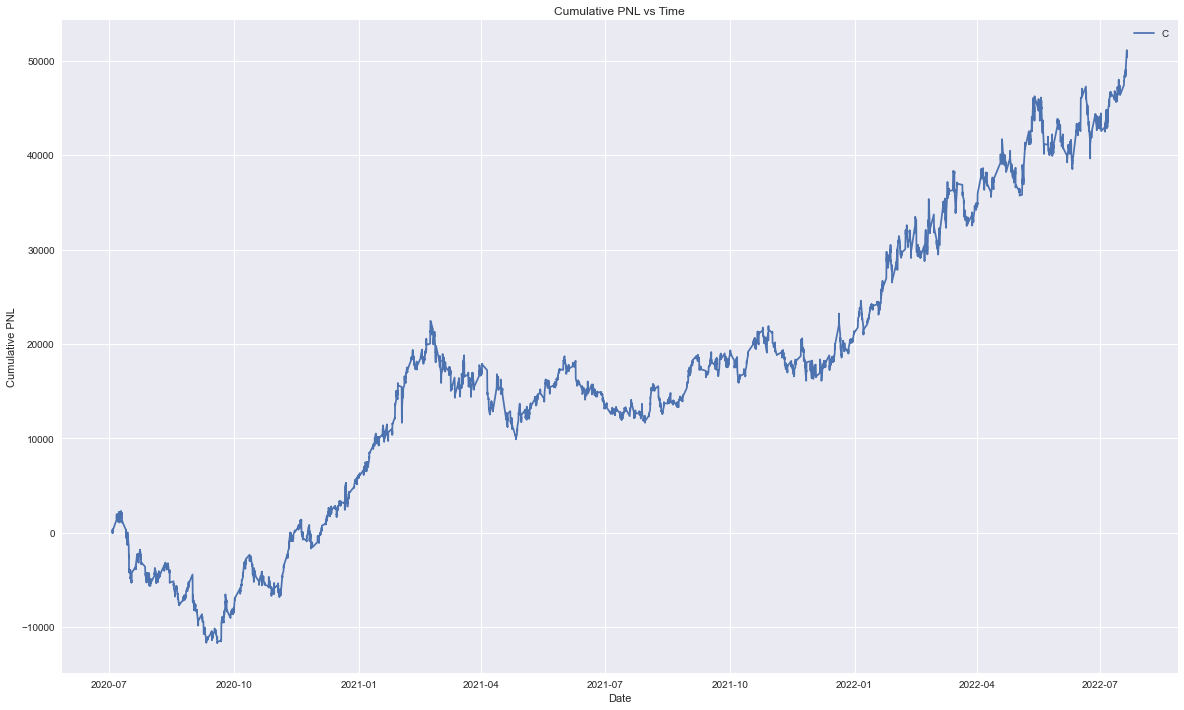

In [45]:
f = plt.figure()
plt.plot(data.index[26:],obj.pnl_date)
plt.xlabel("Date")
plt.ylabel("Cumulative PNL")
plt.title("Cumulative PNL vs Time")
plt.legend("Cumulative PNL")
f.set_figwidth(20)
f.set_figheight(12)

# A properly labelled graph displaying a scatter plot of % returns of all trades.

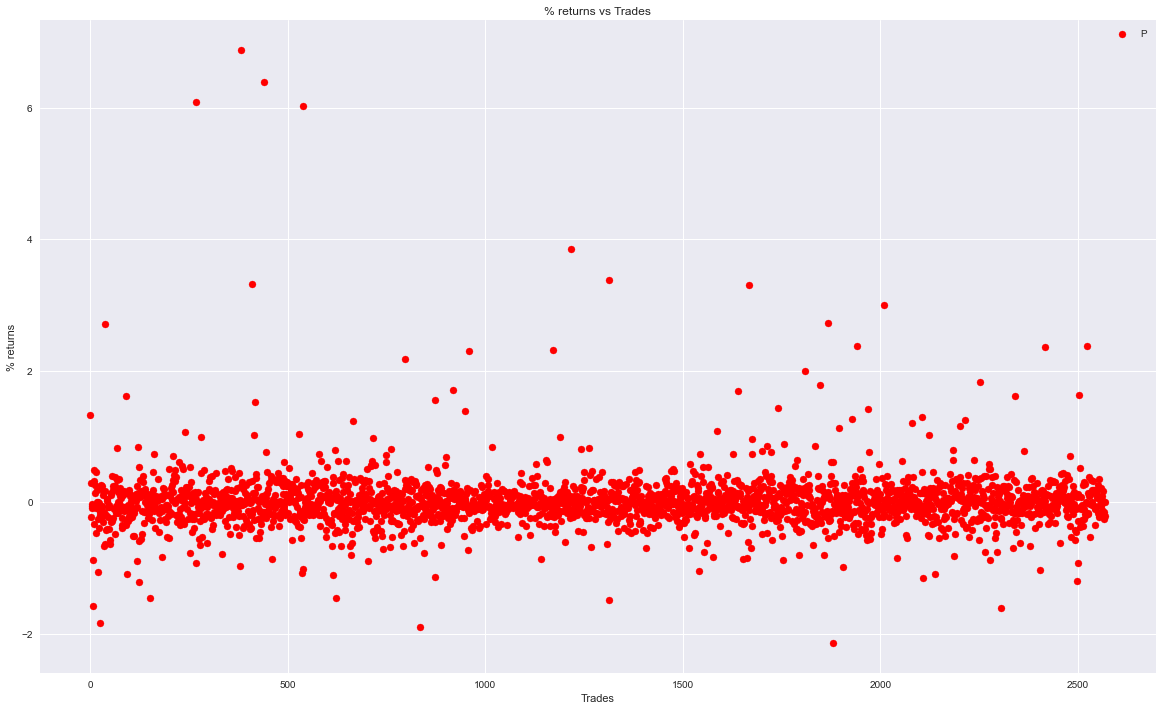

In [46]:
f = plt.figure()
plt.scatter([i for i in range(1,len(pnl_percentage)+1)],pnl_percentage,c ="red")
plt.xlabel("Trades")
plt.ylabel("% returns")
plt.title("% returns vs Trades")
plt.legend("Percentage")
f.set_figwidth(20)
f.set_figheight(12)

# Table for Question-4

In [47]:
gross_profit=0
gross_loss=0
for i in pnl_trades:
    if i>0:
        gross_profit+=i
    else:
        gross_loss+=i

In [48]:
dict={'Total profit':{obj.amount-100000}, 'Initial Capital':100000, 'ROI':(obj.amount-100000)*100/100000, 
     'Win Rate for System':result['Win/Loss'].sum()/len(result),
     'Gross Profits':gross_profit,
     'Gross Losses':gross_loss,
     'Average Profit':gross_profit/len(result),
     'Average Loss':gross_loss/len(result),
     'Max Profit':max(obj.pnl_date),
     'Max Loss':min(obj.pnl_date),
     'Max DD (Money)': max(result['Drawdown (In Rs. from running equity high)']),
     'Max DD (Money as % of running equity high)': max(result['Drawdown (money as a % of running equity high)']),
     'Max DD (Money as % of initial capital)': max(result['Drawdown (money as a % of initial capital)'])
     }
dict

{'Total profit': {50361.74999999968},
 'Initial Capital': 100000,
 'ROI': 50.36174999999968,
 'Win Rate for System': 0.48052959501557635,
 'Gross Profits': 383585.70000000065,
 'Gross Losses': -337210.50000000105,
 'Average Profit': 149.37137850467315,
 'Average Loss': -131.3125000000004,
 'Max Profit': 51120.44999999969,
 'Max Loss': -11684.500000000073,
 'Max DD (Money)': 12907.400000000081,
 'Max DD (Money as % of running equity high)': 12.732531413566162,
 'Max DD (Money as % of initial capital)': 12.90740000000008}

# Data Visualization

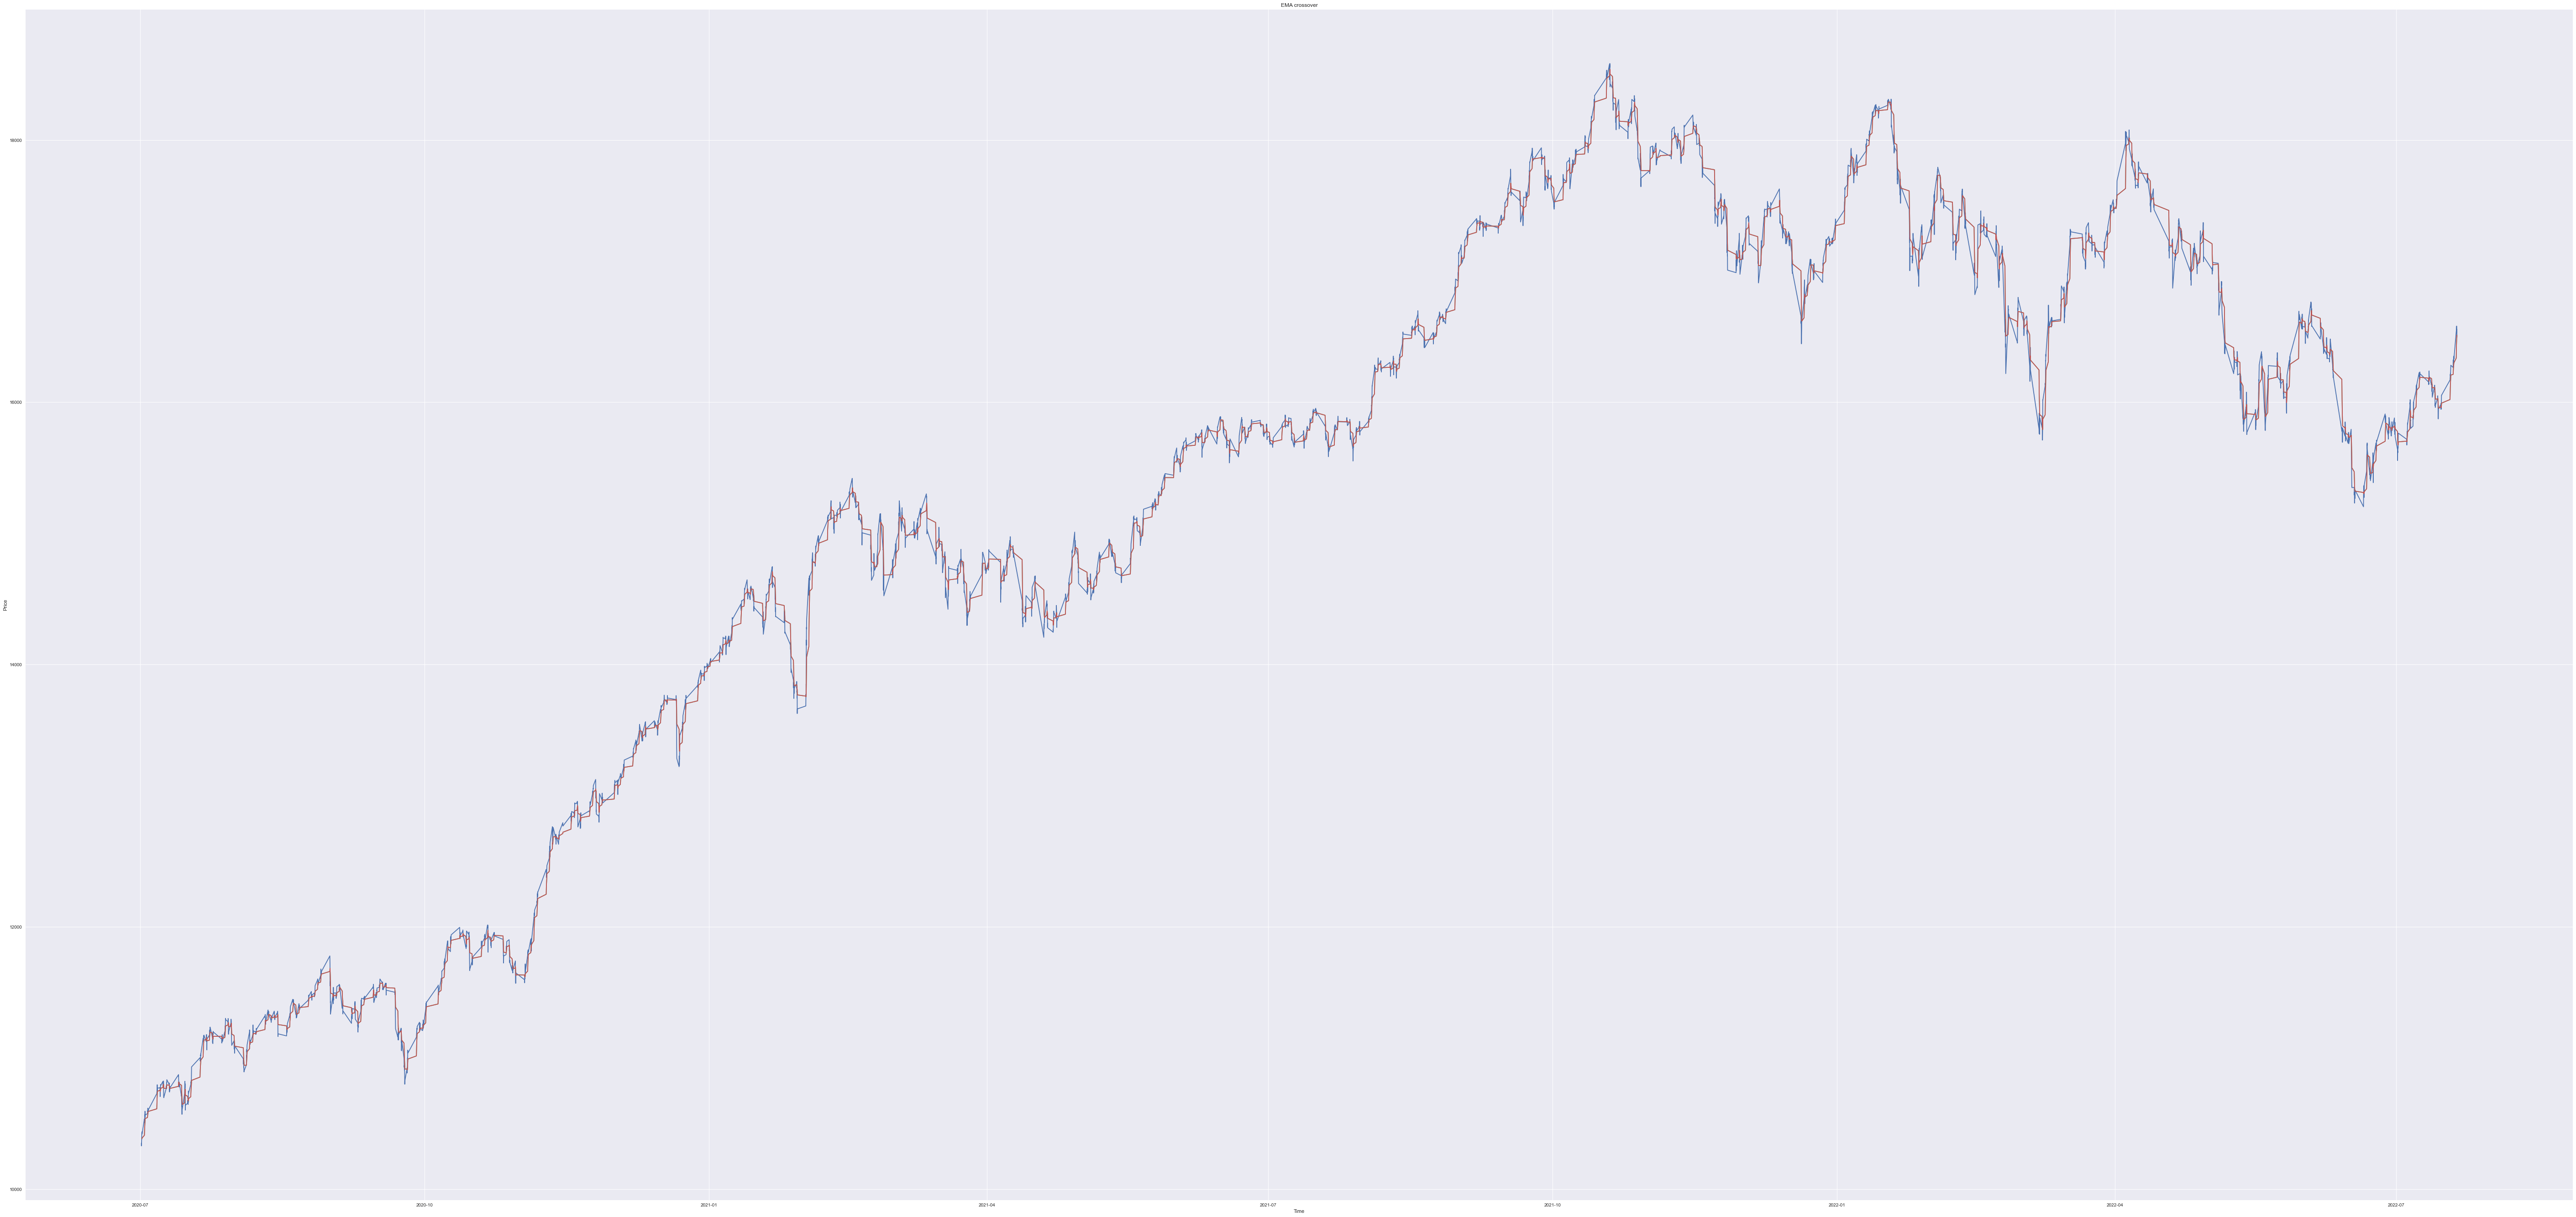

In [54]:
f = plt.figure()
plt.plot(data['Close'])
plt.plot(data['FastMa'])
plt.plot(data['FastMa'])
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("EMA crossover")
f.set_figwidth(100)
f.set_figheight(48)


# plt.savefig('chart.png')

##### For Candlestick Chart

In [283]:
""""Plotly for candlestick is very laggy as it is in early development
candlestick = go.Candlestick(
                            x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close']
                            )

fig = go.Figure(data=[candlestick])

fig.show()
"""

'"\ncandlestick = go.Candlestick(\n                            x=data.index,\n                            open=data[\'Open\'],\n                            high=data[\'High\'],\n                            low=data[\'Low\'],\n                            close=data[\'Close\']\n                            )\n\nfig = go.Figure(data=[candlestick])\n\nfig.show()\n'